In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [250]:
# %pylab inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [251]:
df = pd.read_csv(r'itemGain.csv')
df.head(5)
# bq_df['INSTALL_DATE'] = bq_df['install_date'].str[:10]

,eventDate,accountCreated,userID,configTag,itemNameGain,sourceType,attemptCount,moneySpent,platform,mediaSource,userCountry
0,2022-12-06,2022-11-30T11:32:37.926000,b141f32d-70a2-11ed-9d04-6ae896912cdb,B,USA_M2Light,GachaEventReward,1,0.00,IPhonePlayer,Organic,JP
1,2022-12-06,2022-11-28T20:32:35.366000,cacf5b6d-6f5b-11ed-9083-c26667a54003,A,GER_PanzerjagerI,GachaEventReward,1,0.00,IPhonePlayer,Organic,CA
2,2022-12-06,2022-05-20T02:19:13.224000,3d7e648b-d7e3-11ec-975f-b205715961d6,B,GER_OpelBlitz,GachaEventReward,1,0.00,IPhonePlayer,Organic,TH
3,2022-12-06,2022-10-01T08:46:32.968000,8ce4fdab-4165-11ed-9cd2-2219f00f4034,B,GER_VWType82,GachaEventReward,1,0.00,IPhonePlayer,Organic,DE
4,2022-12-06,2022-12-06T04:03:02.857000,e1578b93-751a-11ed-9d04-6ae896912cdb,A,USA_Rifleman,GachaEventReward,1,1.99,IPhonePlayer,Organic,TH


In [252]:
tier1 = str('US|IL|CA|AT|CH|DE|IT|US|AU|KR|SE|SG|NL|GB|ES|CZ|FR|TW|HU|CY|NZ|IE|BE|DK|NO|FI|JP').split('|')
# tier1
# df = df[(df['userCountry'].isin(tier1))]
# df = df[(df['userCountry'].isin(['US']))]

In [253]:
# copy = df[df['itemNameSpent'] == 'Contracts']
copy = df.copy()
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       7411 non-null   object 
 1   accountCreated  7411 non-null   object 
 2   userID          7411 non-null   object 
 3   configTag       7411 non-null   object 
 4   itemNameGain    7411 non-null   object 
 5   sourceType      7411 non-null   object 
 6   attemptCount    7411 non-null   int64  
 7   moneySpent      7411 non-null   float64
 8   platform        7411 non-null   object 
 9   mediaSource     7411 non-null   object 
 10  userCountry     7411 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 637.0+ KB


In [254]:
# df[df['rev_7day'] > 0].groupby('configTag')['userID'].nunique()
copy.groupby('configTag')['userID'].nunique()

configTag
A    2094
B    2075
Name: userID, dtype: int64

In [255]:
copy[copy['configTag'] == 'A'].describe()

,attemptCount,moneySpent
count,3581.000000,3581.000000
mean,4.097459,151.707928
std,7.281126,546.904798
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,20.960000
max,40.000000,3894.700000


In [256]:
copy[copy['configTag'] == 'B'].describe()

,attemptCount,moneySpent
count,3830.000000,3830.000000
mean,3.967363,131.531076
std,5.159127,402.087523
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,5.000000,24.990000
max,23.000000,2120.470000


In [257]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries.round(decimals=2)

In [258]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [259]:
# copy = df[df['installDate'] <= '2022-10-11']
# arpu_A = copy[copy['configTag'] == 'D']['rev_14day']
# arpu_B = copy[copy['configTag'] == 'E']['rev_14day']
contracts_spent_A = copy[copy['configTag'] == 'A'].groupby('userID')['attemptCount'].count()
contracts_spent_B = copy[copy['configTag'] == 'B'].groupby('userID')['attemptCount'].count()

In [260]:
contracts_spent_A.head(10)

userID
0003385b-78e3-11ed-bade-628a94b2f6a7    4
000770cb-784a-11ed-bade-628a94b2f6a7    1
00664928-6717-11ed-a64c-fe78441d4e7f    3
007f9820-7431-11ed-aa4b-868fa6f74f7c    1
0081f987-7292-11ed-9d04-6ae896912cdb    1
00d7a527-74d3-11ed-aa4b-868fa6f74f7c    1
010f1d20-3bf5-11ed-b41d-8260998f9e8d    3
012e21a7-7174-11ed-aa4b-868fa6f74f7c    1
0142dab7-6501-11ed-a64c-fe78441d4e7f    2
01618b71-4250-11ed-8555-561d121a0fd8    1
Name: attemptCount, dtype: int64

In [261]:
contracts_spent_A.info()
contracts_spent_B.info()

<class 'pandas.core.series.Series'>
Index: 2094 entries, 0003385b-78e3-11ed-bade-628a94b2f6a7 to ffc42f75-721e-11ed-9d04-6ae896912cdb
Series name: attemptCount
Non-Null Count  Dtype
--------------  -----
2094 non-null   int64
dtypes: int64(1)
memory usage: 32.7+ KB
<class 'pandas.core.series.Series'>
Index: 2075 entries, 001c0779-4fdc-11ed-86da-a6799dc2ec30 to ffefc026-720e-11ed-aa4b-868fa6f74f7c
Series name: attemptCount
Non-Null Count  Dtype
--------------  -----
2075 non-null   int64
dtypes: int64(1)
memory usage: 32.4+ KB


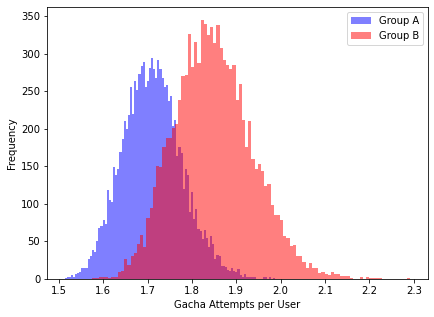

95% confidence interval for mean group A Gacha Attempts per User: [1.59 1.85]
95% confidence interval for mean group B Gacha Attempts per User: [1.69 2.03]


In [262]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(contracts_spent_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(contracts_spent_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Gacha Attempts per User') 
pylab.show()

print("95% confidence interval for mean group A Gacha Attempts per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Gacha Attempts per User:",  stat_intervals(groupB_median_scores, 0.05))

In [263]:
scipy.stats.mannwhitneyu(contracts_spent_A, contracts_spent_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=2176272.5, pvalue=0.44876570981383634)

In [264]:
contracts_spent_A.mean()

1.710124164278892

In [265]:
contracts_spent_B.mean()

1.8457831325301204

In [337]:
# tokens = df[(df['itemNameSpent'] == 'Tokens')]
tokens = pd.read_csv(r'itemSpent.csv')
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       2416 non-null   object 
 1   accountCreated  2416 non-null   object 
 2   userID          2416 non-null   object 
 3   configTag       2416 non-null   object 
 4   itemNameGain    2416 non-null   object 
 5   itemNameSpent   2416 non-null   object 
 6   itemAmount      2416 non-null   float64
 7   itemTypeGain    2416 non-null   object 
 8   moneySpent      2416 non-null   float64
 9   platform        2416 non-null   object 
 10  mediaSource     2416 non-null   object 
 11  userCountry     2416 non-null   object 
dtypes: float64(2), object(10)
memory usage: 226.6+ KB


In [338]:
tokens = tokens[tokens['userID'].isin(copy['userID'])]
tokens.groupby('configTag')['userID'].nunique()

configTag
A    399
B    402
Name: userID, dtype: int64

In [418]:
total_tokens = tokens.groupby('configTag')['itemAmount'].sum()
total_tokens.head()

configTag
A    266200.0
B    294600.0
Name: itemAmount, dtype: float64

In [339]:
tokens_spent_A = tokens[tokens['configTag'] == 'A'].groupby('userID')['itemAmount'].sum()
tokens_spent_B = tokens[tokens['configTag'] == 'B'].groupby('userID')['itemAmount'].sum()

In [340]:
tokens_spent_A.describe()

count      399.000000
mean       667.167920
std       2524.592559
min        200.000000
25%        200.000000
50%        200.000000
75%        400.000000
max      31200.000000
Name: itemAmount, dtype: float64

In [341]:
tokens_spent_B.describe()

count      402.000000
mean       732.835821
std       1914.784692
min        200.000000
25%        200.000000
50%        200.000000
75%        400.000000
max      23600.000000
Name: itemAmount, dtype: float64

In [342]:
[tokens_spent_A[tokens_spent_A.values > 200].count(), tokens_spent_B[tokens_spent_B.values > 200].count()]

[106, 121]

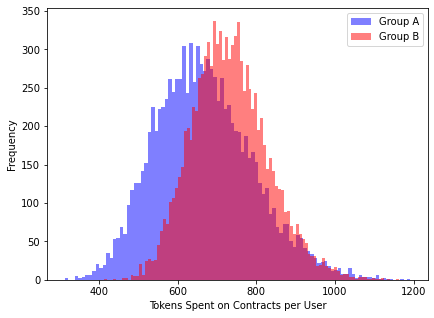

95% confidence interval for mean group A Tokens Spent on Contracts per User: [451.63 940.85]
95% confidence interval for mean group B Tokens Spent on Contracts per User: [561.18 937.81]


In [343]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_spent_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_spent_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Tokens Spent on Contracts per User') 
pylab.show()

print("95% confidence interval for mean group A Tokens Spent on Contracts per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Tokens Spent on Contracts per User:",  stat_intervals(groupB_median_scores, 0.05))

In [344]:
scipy.stats.mannwhitneyu(tokens_spent_A, tokens_spent_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=76531.5, pvalue=0.9210931720879239)

In [275]:
df_gain = pd.read_csv(r'tokens_gained.csv')
df_gain.head(10)
df_gain.info()
# bq_df['INSTALL_DATE'] = bq_df['install_date'].str[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       3934 non-null   object 
 1   accountCreated  3934 non-null   object 
 2   userID          3934 non-null   object 
 3   configTag       3934 non-null   object 
 4   itemNameGain    3934 non-null   object 
 5   sourceType      3934 non-null   object 
 6   itemAmount      3934 non-null   float64
 7   attemptCount    0 non-null      float64
 8   moneySpent      3934 non-null   float64
 9   platform        3934 non-null   object 
 10  mediaSource     3934 non-null   object 
 11  userCountry     3934 non-null   object 
dtypes: float64(3), object(9)
memory usage: 368.9+ KB


In [276]:
df_gain = df_gain[df_gain['userID'].isin(copy['userID'])]
df_gain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555 entries, 1 to 3933
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       1555 non-null   object 
 1   accountCreated  1555 non-null   object 
 2   userID          1555 non-null   object 
 3   configTag       1555 non-null   object 
 4   itemNameGain    1555 non-null   object 
 5   sourceType      1555 non-null   object 
 6   itemAmount      1555 non-null   float64
 7   attemptCount    0 non-null      float64
 8   moneySpent      1555 non-null   float64
 9   platform        1555 non-null   object 
 10  mediaSource     1555 non-null   object 
 11  userCountry     1555 non-null   object 
dtypes: float64(3), object(9)
memory usage: 157.9+ KB


In [277]:
tokens_gained_A = df_gain[df_gain['configTag'] == 'A'].groupby('userID')['itemAmount'].sum()
tokens_gained_B = df_gain[df_gain['configTag'] == 'B'].groupby('userID')['itemAmount'].sum()

In [278]:
tokens_gained_A.describe()

count      229.000000
mean      2550.218341
std       5698.191460
min        100.000000
25%        300.000000
50%        600.000000
75%       1800.000000
max      48850.000000
Name: itemAmount, dtype: float64

In [279]:
tokens_gained_B.describe()

count      252.000000
mean      2219.841270
std       4563.319803
min        100.000000
25%        300.000000
50%        600.000000
75%       1925.000000
max      43000.000000
Name: itemAmount, dtype: float64

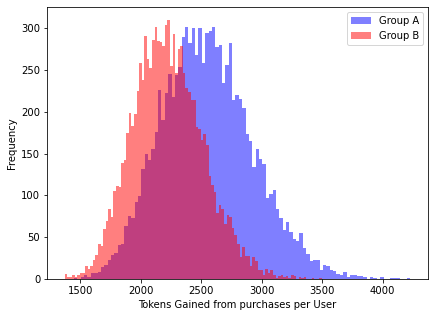

95% confidence interval for mean group A Tokens Gained from purchases  per User: [1876.84 3336.36]
95% confidence interval for mean group B Tokens Gained from purchases per User: [1702.57 2831.16]


In [280]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_gained_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_gained_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Tokens Gained from purchases per User') 
pylab.show()

print("95% confidence interval for mean group A Tokens Gained from purchases  per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Tokens Gained from purchases per User:",  stat_intervals(groupB_median_scores, 0.05))

In [281]:
scipy.stats.mannwhitneyu(tokens_gained_A, tokens_gained_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=28798.0, pvalue=0.5148241513332528)

In [370]:
df_purchased = pd.read_csv(r'token_purchases.csv')
df_purchased.head(10)
df_purchased.info()
# bq_df['INSTALL_DATE'] = bq_df['install_date'].str[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       918 non-null    object 
 1   accountCreated  918 non-null    object 
 2   userID          918 non-null    object 
 3   configTag       918 non-null    object 
 4   productName     918 non-null    object 
 5   configPrice     918 non-null    float64
 6   moneySpent      918 non-null    float64
 7   platform        918 non-null    object 
 8   mediaSource     918 non-null    object 
 9   userCountry     918 non-null    object 
dtypes: float64(2), object(8)
memory usage: 71.8+ KB


In [371]:
df_purchased = df_purchased[df_purchased['userID'].isin(copy['userID'])]
df_purchased.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 914
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       457 non-null    object 
 1   accountCreated  457 non-null    object 
 2   userID          457 non-null    object 
 3   configTag       457 non-null    object 
 4   productName     457 non-null    object 
 5   configPrice     457 non-null    float64
 6   moneySpent      457 non-null    float64
 7   platform        457 non-null    object 
 8   mediaSource     457 non-null    object 
 9   userCountry     457 non-null    object 
dtypes: float64(2), object(8)
memory usage: 39.3+ KB


In [417]:
total_purchased = df_purchased.groupby('configTag')['configPrice'].sum()
total_purchased.head()

configTag
A    2656.62
B    2689.81
Name: configPrice, dtype: float64

In [372]:
tokens_purchased_A = df_purchased[df_purchased['configTag'] == 'A'].groupby('userID')['configPrice'].sum()
tokens_purchased_B = df_purchased[df_purchased['configTag'] == 'B'].groupby('userID')['configPrice'].sum()

In [373]:
tokens_purchased_A.describe()

count     85.000000
mean      31.254353
std       58.948185
min        0.990000
25%        3.960000
50%        9.990000
75%       24.960000
max      340.910000
Name: configPrice, dtype: float64

In [374]:
tokens_purchased_B.describe()

count    102.000000
mean      26.370686
std       51.015618
min        0.990000
25%        2.227500
50%        9.990000
75%       28.462500
max      349.950000
Name: configPrice, dtype: float64

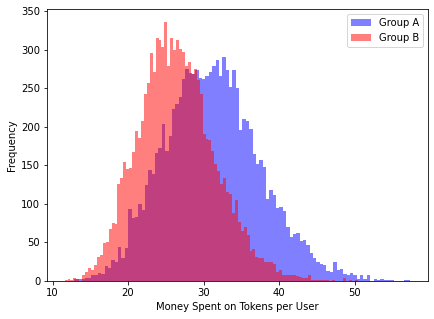

95% confidence interval for mean group A Money Spent on Tokens per User: [20.01 44.32]
95% confidence interval for mean group B Money Spent on Tokens per User: [17.46 37.27]


In [375]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_purchased_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(tokens_purchased_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Money Spent on Tokens per User') 
pylab.show()

print("95% confidence interval for mean group A Money Spent on Tokens per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Money Spent on Tokens per User:",  stat_intervals(groupB_median_scores, 0.05))

In [376]:
scipy.stats.mannwhitneyu(tokens_purchased_A, tokens_purchased_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=4498.5, pvalue=0.32818135443422003)

In [377]:
attemptsBySpend = df.copy()
attemptsBySpend['SpendTier'] = ''
attemptsBySpend['moneySpent'] = attemptsBySpend['moneySpent'] * 1.0
attemptsBySpend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eventDate       7411 non-null   object 
 1   accountCreated  7411 non-null   object 
 2   userID          7411 non-null   object 
 3   configTag       7411 non-null   object 
 4   itemNameGain    7411 non-null   object 
 5   sourceType      7411 non-null   object 
 6   attemptCount    7411 non-null   int64  
 7   moneySpent      7411 non-null   float64
 8   platform        7411 non-null   object 
 9   mediaSource     7411 non-null   object 
 10  userCountry     7411 non-null   object 
 11  SpendTier       7411 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 694.9+ KB


In [378]:
attemptsBySpend.head(10)

,eventDate,accountCreated,userID,configTag,itemNameGain,sourceType,attemptCount,moneySpent,platform,mediaSource,userCountry,SpendTier
0,2022-12-06,2022-11-30T11:32:37.926000,b141f32d-70a2-11ed-9d04-6ae896912cdb,B,USA_M2Light,GachaEventReward,1,0.00,IPhonePlayer,Organic,JP,
1,2022-12-06,2022-11-28T20:32:35.366000,cacf5b6d-6f5b-11ed-9083-c26667a54003,A,GER_PanzerjagerI,GachaEventReward,1,0.00,IPhonePlayer,Organic,CA,
2,2022-12-06,2022-05-20T02:19:13.224000,3d7e648b-d7e3-11ec-975f-b205715961d6,B,GER_OpelBlitz,GachaEventReward,1,0.00,IPhonePlayer,Organic,TH,
3,2022-12-06,2022-10-01T08:46:32.968000,8ce4fdab-4165-11ed-9cd2-2219f00f4034,B,GER_VWType82,GachaEventReward,1,0.00,IPhonePlayer,Organic,DE,
4,2022-12-06,2022-12-06T04:03:02.857000,e1578b93-751a-11ed-9d04-6ae896912cdb,A,USA_Rifleman,GachaEventReward,1,1.99,IPhonePlayer,Organic,TH,
5,2022-12-06,2022-12-02T20:44:38.245000,2354ffc8-7282-11ed-aa4b-868fa6f74f7c,B,GER_VWType82,GachaEventReward,2,1.99,IPhonePlayer,Organic,IT,
6,2022-12-06,2022-11-24T08:09:53.645000,604d655c-6bcf-11ed-a64c-fe78441d4e7f,A,GER_VWType82,GachaEventReward,1,0.00,IPhonePlayer,Organic,TW,
7,2022-12-06,2022-12-05T01:12:55.576000,f2ea5a22-7439-11ed-aa4b-868fa6f74f7c,A,USA_M3Scout,GachaEventReward,1,0.00,IPhonePlayer,Organic,US,
8,2022-12-06,2022-11-20T15:57:06.084000,fb494bc2-68eb-11ed-a64c-fe78441d4e7f,B,GER_GRW34,GachaEventReward,5,379.67,IPhonePlayer,Organic,CH,
9,2022-12-06,2022-11-20T15:57:06.084000,fb494bc2-68eb-11ed-a64c-fe78441d4e7f,B,USA_M2Light,GachaEventReward,5,379.67,IPhonePlayer,Organic,CH,


In [379]:
attempts_by_spend_A = attemptsBySpend[attemptsBySpend['configTag'] == 'A'].groupby('userID').agg(moneySpent = ('moneySpent', max), attempts = ('attemptCount', max))
attempts_by_spend_B = attemptsBySpend[attemptsBySpend['configTag'] == 'B'].groupby('userID').agg(moneySpent = ('moneySpent', max), attempts = ('attemptCount', max))

In [380]:
attempts_by_spend_A.head()
# attempts_by_spend_A.info()

,moneySpent,attempts
userID,,
0003385b-78e3-11ed-bade-628a94b2f6a7,38.95,4
000770cb-784a-11ed-bade-628a94b2f6a7,0.00,1
00664928-6717-11ed-a64c-fe78441d4e7f,94.62,3
007f9820-7431-11ed-aa4b-868fa6f74f7c,0.00,1
0081f987-7292-11ed-9d04-6ae896912cdb,1.99,1


In [381]:
for i, row in attempts_by_spend_A.iterrows():
    attempts_by_spend_A.loc[i, 'SpendTier'] = \
    '0$' if attempts_by_spend_A.loc[i, 'moneySpent'] == 0 else \
    '1-8$' if ((attempts_by_spend_A.loc[i, 'moneySpent'] > 0) and (attempts_by_spend_A.loc[i, 'moneySpent'] <= 8)) else \
    '9-24$' if ((attempts_by_spend_A.loc[i, 'moneySpent'] > 8) and (attempts_by_spend_A.loc[i, 'moneySpent'] <= 24)) else \
    '25-108$' if ((attempts_by_spend_A.loc[i, 'moneySpent'] > 24) and (attempts_by_spend_A.loc[i, 'moneySpent'] <= 108)) else \
    '109-209$' if ((attempts_by_spend_A.loc[i, 'moneySpent'] > 108) and (attempts_by_spend_A.loc[i, 'moneySpent'] <= 209)) else \
    '>= 210$' if ((attempts_by_spend_A.loc[i, 'moneySpent'] > 209)) else ''

In [382]:
attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '>= 210$'].head(10)

,moneySpent,attempts,SpendTier
userID,,,
0e39e453-d1d2-11ec-90b4-42adde5b88ba,3894.70,40,>= 210$
105b2d66-0b13-11ed-a76b-9645b968bedb,1041.07,6,>= 210$
13492576-338a-11ed-a663-e6cce5d09abb,231.77,3,>= 210$
16fa4278-22d8-11ed-9755-8a4ca7d05cea,541.69,2,>= 210$
1d9f601a-3322-11ed-a663-e6cce5d09abb,918.42,16,>= 210$
24a73f9a-1544-11ed-90f6-2a5c5d4e2af7,306.58,2,>= 210$
2f5a0039-c2c6-11eb-a2bb-06c9cb951f1a,608.82,40,>= 210$
438cd07a-3357-11ed-a663-e6cce5d09abb,811.84,7,>= 210$
47c716db-1baa-11ed-9b08-9e20d892af40,278.81,6,>= 210$


In [383]:
for i, row in attempts_by_spend_B.iterrows():
    attempts_by_spend_B.loc[i, 'SpendTier'] = \
    '0$' if attempts_by_spend_B.loc[i, 'moneySpent'] == 0 else \
    '1-8$' if ((attempts_by_spend_B.loc[i, 'moneySpent'] > 0) and (attempts_by_spend_B.loc[i, 'moneySpent'] <= 8)) else \
    '9-24$' if ((attempts_by_spend_B.loc[i, 'moneySpent'] > 8) and (attempts_by_spend_B.loc[i, 'moneySpent'] <= 24)) else \
    '25-108$' if ((attempts_by_spend_B.loc[i, 'moneySpent'] > 24) and (attempts_by_spend_B.loc[i, 'moneySpent'] <= 108)) else \
    '109-209$' if ((attempts_by_spend_B.loc[i, 'moneySpent'] > 108) and (attempts_by_spend_B.loc[i, 'moneySpent'] <= 209)) else \
    '>= 210$' if ((attempts_by_spend_B.loc[i, 'moneySpent'] > 209)) else ''

In [384]:
aggreagate_attempts_A = attempts_by_spend_A.groupby('SpendTier')['attempts'].sum()
aggreagate_attempts_B = attempts_by_spend_B.groupby('SpendTier')['attempts'].sum()

In [385]:
aggreagate_attempts_A.head(10)

SpendTier
0$          2345
1-8$         161
109-209$     157
25-108$      293
9-24$        194
>= 210$      417
Name: attempts, dtype: int64

In [386]:
# aggreagate_attempts_A.map({'0$': 0, '1-8$': 1, '9-24$': 2, '25-108$': 3, '109-209$': 4, '>= 210$': 5}).sort_values(by=['SpendTier']).head(10)
aggreagate_attempts_B.head(10)

SpendTier
0$          2383
1-8$         173
109-209$     146
25-108$      329
9-24$        236
>= 210$      348
Name: attempts, dtype: int64

In [387]:
spend_zero = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '0$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '0$']['attempts'], use_continuity=True, alternative='greater')
spend_8 = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '1-8$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '1-8$']['attempts'], use_continuity=True, alternative='greater')
spend_24 = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '9-24$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '9-24$']['attempts'], use_continuity=True, alternative='greater')
spend_100 = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '25-108$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '25-108$']['attempts'], use_continuity=True, alternative='greater')
spend_200 = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '109-209$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '109-209$']['attempts'], use_continuity=True, alternative='greater')
spend_more = scipy.stats.mannwhitneyu(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '>= 210$']['attempts'], attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '>= 210$']['attempts'], use_continuity=True, alternative='greater')

In [388]:
print(spend_zero)
print(spend_8)
print(spend_24)
print(spend_100)
print(spend_200)
print(spend_more)

MannwhitneyuResult(statistic=1433767.5, pvalue=0.417332057529219)
MannwhitneyuResult(statistic=6419.0, pvalue=0.6504185823978733)
MannwhitneyuResult(statistic=5016.5, pvalue=0.6807704566246426)
MannwhitneyuResult(statistic=6291.5, pvalue=0.3764890328311058)
MannwhitneyuResult(statistic=342.0, pvalue=0.7308165501925543)
MannwhitneyuResult(statistic=538.5, pvalue=0.9525015798822274)


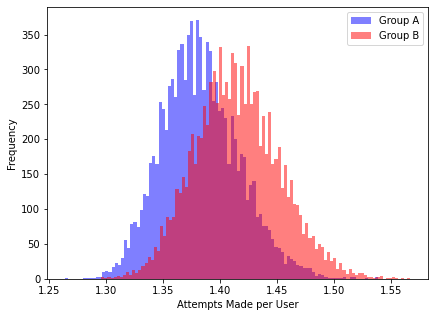

95% confidence interval for mean group A Attempts Made per User: [1.32 1.45]
95% confidence interval for mean group B Attempts Made per User: [1.35 1.49]


In [389]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '0$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '0$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

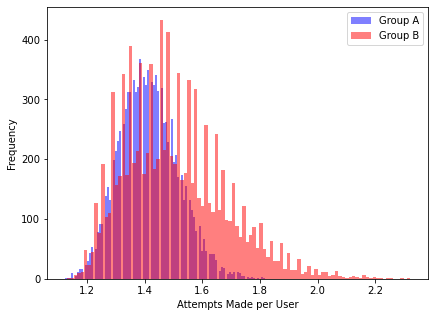

95% confidence interval for mean group A Attempts Made per User: [1.23 1.62]
95% confidence interval for mean group B Attempts Made per User: [1.23 1.9 ]


In [390]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '1-8$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '1-8$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

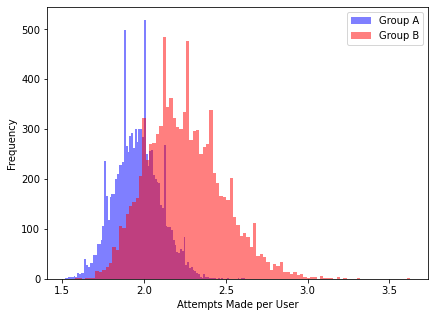

95% confidence interval for mean group A Attempts Made per User: [1.7  2.24]
95% confidence interval for mean group B Attempts Made per User: [1.85 2.74]


In [391]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '9-24$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '9-24$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

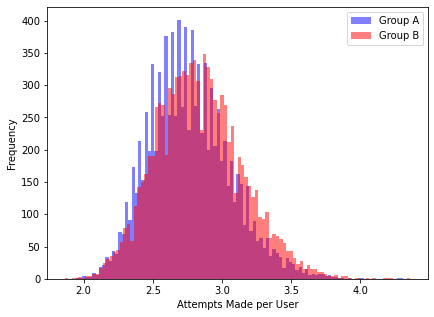

95% confidence interval for mean group A Attempts Made per User: [2.26 3.41]
95% confidence interval for mean group B Attempts Made per User: [2.28 3.49]


In [392]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '25-108$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '25-108$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

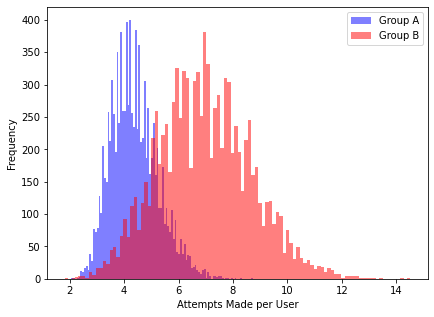

95% confidence interval for mean group A Attempts Made per User: [2.94 6.31]
95% confidence interval for mean group B Attempts Made per User: [ 3.86 10.43]


In [393]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '109-209$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '109-209$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

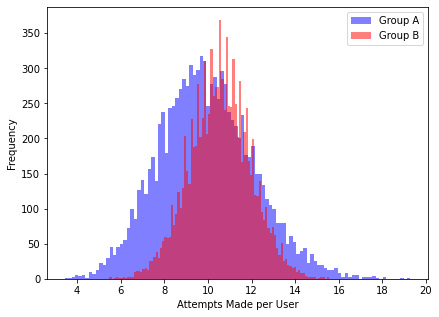

95% confidence interval for mean group A Attempts Made per User: [ 6.   14.48]
95% confidence interval for mean group B Attempts Made per User: [ 7.79 13.27]


In [394]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_A[attempts_by_spend_A['SpendTier'] == '>= 210$']['attempts'].values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(attempts_by_spend_B[attempts_by_spend_B['SpendTier'] == '>= 210$']['attempts'].values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Attempts Made per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

In [395]:
hist_A = attemptsBySpend[attemptsBySpend['configTag'] == 'A']['moneySpent'].copy()
hist_A = hist_A[hist_A != 0]
hist_B = attemptsBySpend[attemptsBySpend['configTag'] == 'B']['moneySpent'].copy()
hist_B = hist_B[hist_B != 0]

In [396]:
hist_A.describe()

count    1238.000000
mean      438.825598
std       859.966581
min         0.990000
25%        17.980000
50%        82.910000
75%       507.570000
max      3894.700000
Name: moneySpent, dtype: float64

In [397]:
hist_B.describe()

count    1403.000000
mean      359.062024
std       599.827175
min         0.990000
25%        14.980000
50%        78.780000
75%       384.610000
max      2120.470000
Name: moneySpent, dtype: float64

In [398]:
hist_A.head(10)

4        1.99
23      49.95
39      29.96
41     123.87
42     123.87
43       6.98
44      84.91
60      21.95
66       1.99
68    1041.07
Name: moneySpent, dtype: float64

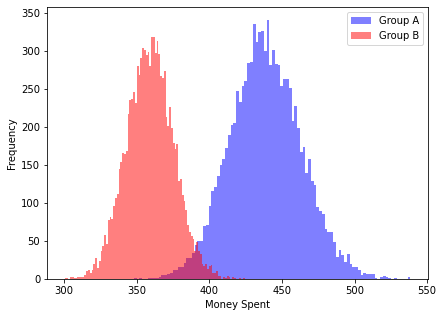

95% confidence interval for mean group A Attempts Made per User by Money Spent: [392.02 487.55]
95% confidence interval for mean group B Attempts Made per User by Money Spent: [328.06 391.53]


In [399]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(hist_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(hist_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Money Spent') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User by Money Spent:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User by Money Spent:",  stat_intervals(groupB_median_scores, 0.05))

In [400]:
scipy.stats.mannwhitneyu(hist_A, hist_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=892184.0, pvalue=0.11248427361586816)

In [401]:
max_money_spent = attemptsBySpend.groupby('userID')['moneySpent'].max()

max_money_spent

userID
0003385b-78e3-11ed-bade-628a94b2f6a7    38.95
000770cb-784a-11ed-bade-628a94b2f6a7     0.00
001c0779-4fdc-11ed-86da-a6799dc2ec30     0.00
0027e54c-63a7-11ed-a64c-fe78441d4e7f     0.00
0065b4ec-722d-11ed-9d04-6ae896912cdb     0.00
                                        ...  
ffcbeb3a-7603-11ed-8a5c-76360256d21b    33.96
ffd4a385-2916-11ed-9755-8a4ca7d05cea    95.87
ffe9338d-6f2d-11ed-a64c-fe78441d4e7f     0.00
ffed4d8d-d07e-11ec-8b6b-aa5277066c94     0.00
ffefc026-720e-11ed-aa4b-868fa6f74f7c     0.00
Name: moneySpent, Length: 4169, dtype: float64

In [402]:
diff_attempts_by_spend = attemptsBySpend.copy()
diff_attempts_by_spend['maxSpend'] = 0

for i, row in diff_attempts_by_spend.iterrows():
    if diff_attempts_by_spend.loc[i, 'userID'] in max_money_spent.index:
        diff_attempts_by_spend.loc[i, 'maxSpend'] = max_money_spent[diff_attempts_by_spend.loc[i, 'userID']]

In [403]:
diff_attempts_by_spend.head(10)

,eventDate,accountCreated,userID,configTag,itemNameGain,sourceType,attemptCount,moneySpent,platform,mediaSource,userCountry,SpendTier,maxSpend
0,2022-12-06,2022-11-30T11:32:37.926000,b141f32d-70a2-11ed-9d04-6ae896912cdb,B,USA_M2Light,GachaEventReward,1,0.00,IPhonePlayer,Organic,JP,,0.00
1,2022-12-06,2022-11-28T20:32:35.366000,cacf5b6d-6f5b-11ed-9083-c26667a54003,A,GER_PanzerjagerI,GachaEventReward,1,0.00,IPhonePlayer,Organic,CA,,0.00
2,2022-12-06,2022-05-20T02:19:13.224000,3d7e648b-d7e3-11ec-975f-b205715961d6,B,GER_OpelBlitz,GachaEventReward,1,0.00,IPhonePlayer,Organic,TH,,0.00
3,2022-12-06,2022-10-01T08:46:32.968000,8ce4fdab-4165-11ed-9cd2-2219f00f4034,B,GER_VWType82,GachaEventReward,1,0.00,IPhonePlayer,Organic,DE,,0.00
4,2022-12-06,2022-12-06T04:03:02.857000,e1578b93-751a-11ed-9d04-6ae896912cdb,A,USA_Rifleman,GachaEventReward,1,1.99,IPhonePlayer,Organic,TH,,11.98
5,2022-12-06,2022-12-02T20:44:38.245000,2354ffc8-7282-11ed-aa4b-868fa6f74f7c,B,GER_VWType82,GachaEventReward,2,1.99,IPhonePlayer,Organic,IT,,1.99
6,2022-12-06,2022-11-24T08:09:53.645000,604d655c-6bcf-11ed-a64c-fe78441d4e7f,A,GER_VWType82,GachaEventReward,1,0.00,IPhonePlayer,Organic,TW,,0.00
7,2022-12-06,2022-12-05T01:12:55.576000,f2ea5a22-7439-11ed-aa4b-868fa6f74f7c,A,USA_M3Scout,GachaEventReward,1,0.00,IPhonePlayer,Organic,US,,0.00
8,2022-12-06,2022-11-20T15:57:06.084000,fb494bc2-68eb-11ed-a64c-fe78441d4e7f,B,GER_GRW34,GachaEventReward,5,379.67,IPhonePlayer,Organic,CH,,417.64
9,2022-12-06,2022-11-20T15:57:06.084000,fb494bc2-68eb-11ed-a64c-fe78441d4e7f,B,USA_M2Light,GachaEventReward,5,379.67,IPhonePlayer,Organic,CH,,417.64


In [404]:
diff_hist_A = diff_attempts_by_spend[diff_attempts_by_spend['configTag'] == 'A']['maxSpend']
diff_hist_A = diff_hist_A[diff_hist_A != 0]
diff_hist_B = diff_attempts_by_spend[diff_attempts_by_spend['configTag'] == 'B']['maxSpend']
diff_hist_B = diff_hist_B[diff_hist_B != 0]

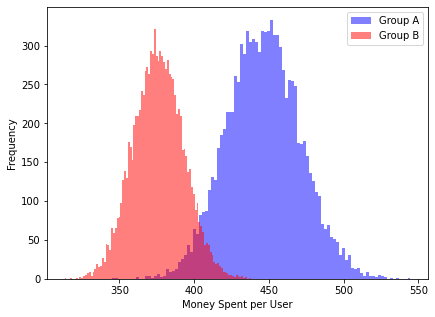

95% confidence interval for mean group A Attempts Made per User: [399.8  494.94]
95% confidence interval for mean group B Attempts Made per User: [343.36 409.2 ]


In [405]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(diff_hist_A.values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(diff_hist_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Money Spent per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

In [406]:
scipy.stats.mannwhitneyu(diff_hist_A, diff_hist_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=898267.0, pvalue=0.1687542465127322)

In [407]:
diff_max_spent_A = attemptsBySpend[attemptsBySpend['configTag'] == 'A'].groupby('userID')['moneySpent'].max()
diff_max_spent_B = attemptsBySpend[attemptsBySpend['configTag'] == 'B'].groupby('userID')['moneySpent'].max()

In [408]:
diff_max_spent_A = diff_max_spent_A[diff_max_spent_A != 0]
diff_max_spent_B = diff_max_spent_B[diff_max_spent_B != 0]

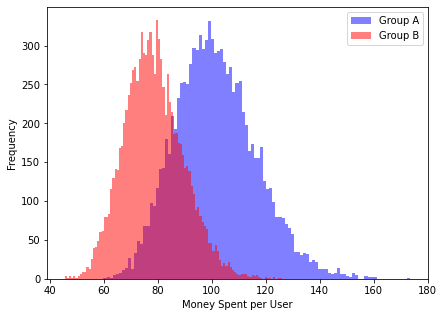

95% confidence interval for mean group A Attempts Made per User: [ 75.5  133.69]
95% confidence interval for mean group B Attempts Made per User: [ 58.86 101.39]


In [409]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(diff_max_spent_A .values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(diff_max_spent_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Money Spent per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

In [410]:
scipy.stats.mannwhitneyu(diff_max_spent_A, diff_max_spent_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=80769.5, pvalue=0.14630154276547536)

In [411]:
max_spent_A = attemptsBySpend[attemptsBySpend['configTag'] == 'A'].groupby(['userID', 'moneySpent']).size().reset_index()
max_spent_B = attemptsBySpend[attemptsBySpend['configTag'] == 'B'].groupby(['userID', 'moneySpent']).size().reset_index()

In [412]:
#attemptsBySpend[attemptsBySpend['configTag'] == 'A'].shape
max_spent_A.head()

,userID,moneySpent,0
0,0003385b-78e3-11ed-bade-628a94b2f6a7,38.95,4
1,000770cb-784a-11ed-bade-628a94b2f6a7,0.00,1
2,00664928-6717-11ed-a64c-fe78441d4e7f,46.77,1
3,00664928-6717-11ed-a64c-fe78441d4e7f,85.67,1
4,00664928-6717-11ed-a64c-fe78441d4e7f,94.62,1


In [413]:
max_spent_A = max_spent_A['moneySpent']
max_spent_B = max_spent_B['moneySpent']

In [414]:
max_spent_A = max_spent_A[max_spent_A != 0]
max_spent_B = max_spent_B[max_spent_B != 0]

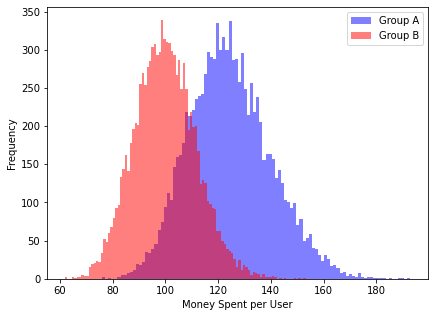

95% confidence interval for mean group A Attempts Made per User: [ 97.01 156.79]
95% confidence interval for mean group B Attempts Made per User: [ 78.18 123.88]


In [415]:
groupA_median_scores = list(map(np.mean, get_bootstrap_samples(max_spent_A .values, 10000)))
groupB_median_scores = list(map(np.mean, get_bootstrap_samples(max_spent_B.values, 10000)))

pylab.figure(figsize(15, 5))
pylab.subplot(1,2,1)
pylab.hist(groupA_median_scores, alpha = .5, color = 'b', label = 'Group A', bins = 100)
pylab.legend()

pylab.subplot(1,2,1)
pylab.hist(groupB_median_scores, alpha = .5, color = 'r', label = 'Group B', bins = 100)
pylab.legend()

# pylab.subplot(1,2,1)
# pylab.hist(groupC_median_scores, alpha = .5, color = 'g', label = 'Group C ARPU 1d', bins = 100)
# pylab.legend()

pylab.ylabel('Frequency') 
pylab.xlabel('Money Spent per User') 
pylab.show()

print("95% confidence interval for mean group A Attempts Made per User:",  stat_intervals(groupA_median_scores, 0.05))
print("95% confidence interval for mean group B Attempts Made per User:",  stat_intervals(groupB_median_scores, 0.05))

In [416]:
scipy.stats.mannwhitneyu(max_spent_A, max_spent_B, use_continuity=True, alternative='greater')

MannwhitneyuResult(statistic=114030.0, pvalue=0.1359142602256871)